In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
# --- Bước 1: LOAD DỮ LIỆU ---

file_path = 'Food_Delivery_Times.csv'
df = pd.read_csv(file_path)
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [15]:
# Hiển thị thống kê mô tả các cột
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [25]:
# Xác định cột mục tiêu (target variable) là 'Delivery_Time_min'
target_column = 'Delivery_Time_min'

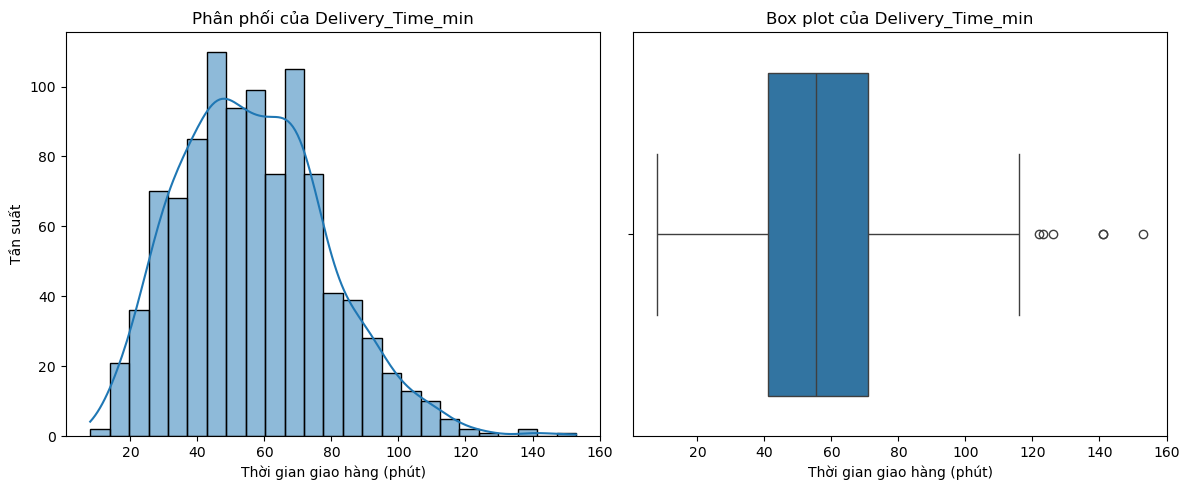

In [37]:
# --- Bước 2: KHAI PHÁ DỮ LIỆU (EDA) ---

# Phân tích biến mục tiêu (Delivery_Time_min)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # 1 hàng, 2 cột, vị trí 1
sns.histplot(df[target_column], kde=True)
plt.title(f'Phân phối của {target_column}')
plt.xlabel('Thời gian giao hàng (phút)')
plt.ylabel('Tần suất')

plt.subplot(1, 2, 2) # 1 hàng, 2 cột, vị trí 2
sns.boxplot(x=df[target_column])
plt.title(f'Box plot của {target_column}')
plt.xlabel('Thời gian giao hàng (phút)')
plt.tight_layout() # Điều chỉnh layout cho đẹp
plt.show()

In [27]:
# Xác định các cột features dựa trên mô tả và kiểm tra sự tồn tại
numerical_features = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs'] # Khoảng cách, Thời gian chuẩn bị món, Số năm kinh nghiệm giao hàng
categorical_features = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'] # Thời tiết, Tình trạng giao thông, Khoảng thời gian đặt món, Loại phương tiện giao hàng

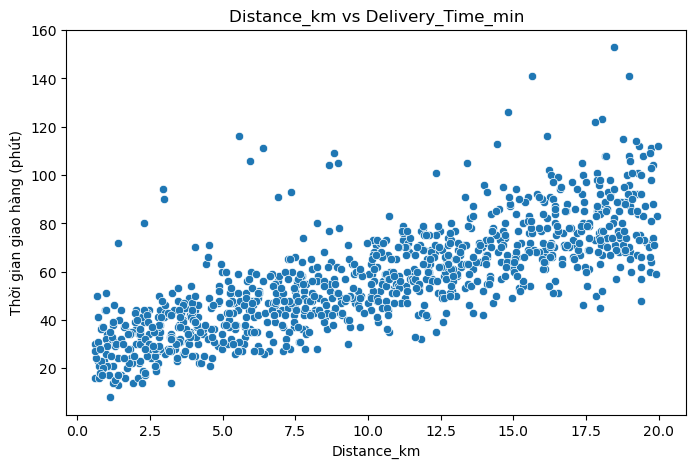

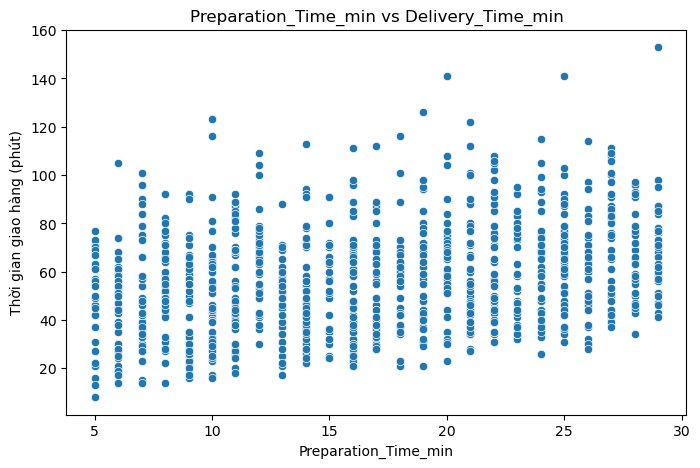

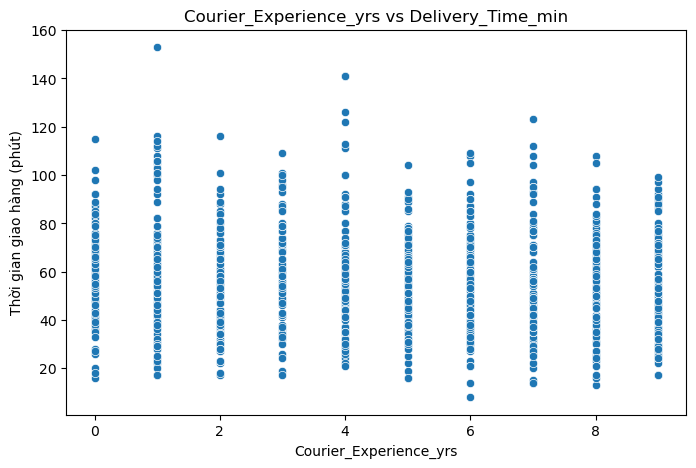

In [43]:
# Phân tích mối quan hệ: Biến số và Biến mục tiêu
for col in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[col], y=df[target_column])
    plt.title(f'{col} vs {target_column}')
    plt.xlabel(col)
    plt.ylabel('Thời gian giao hàng (phút)')
    plt.show()

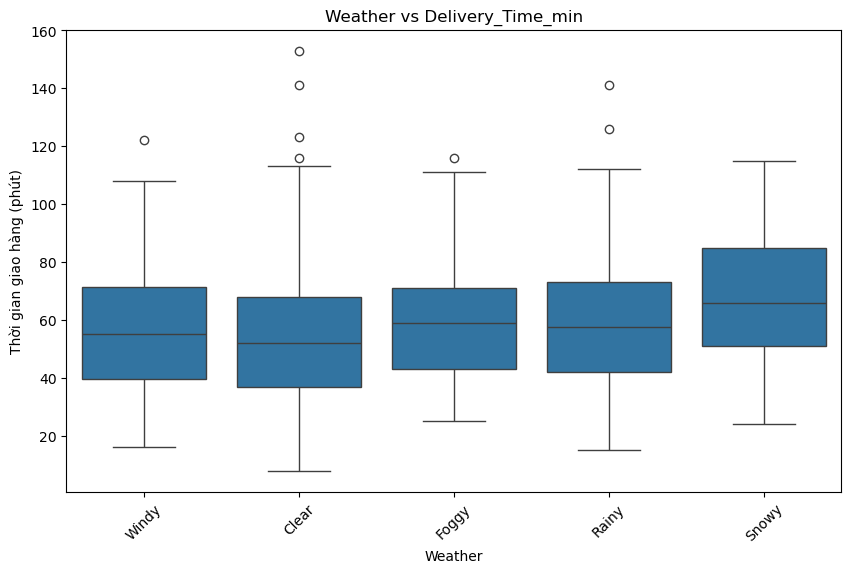

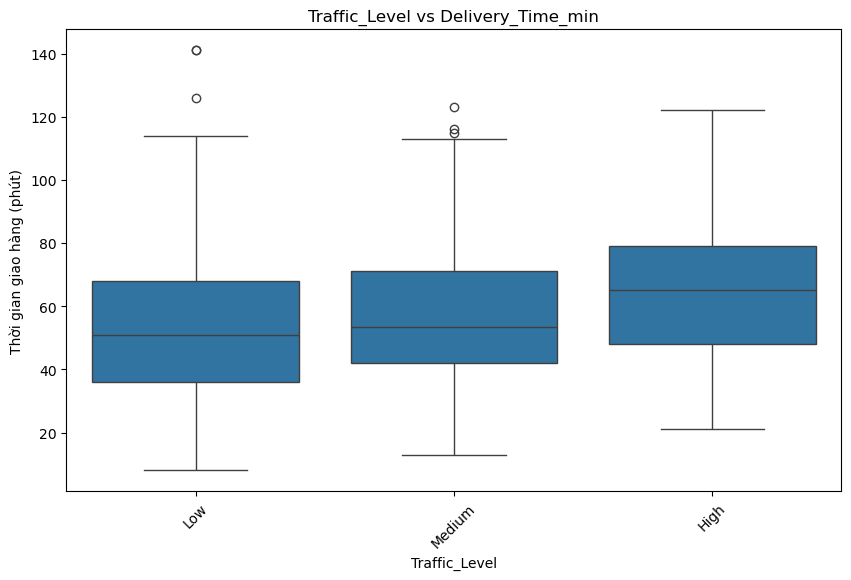

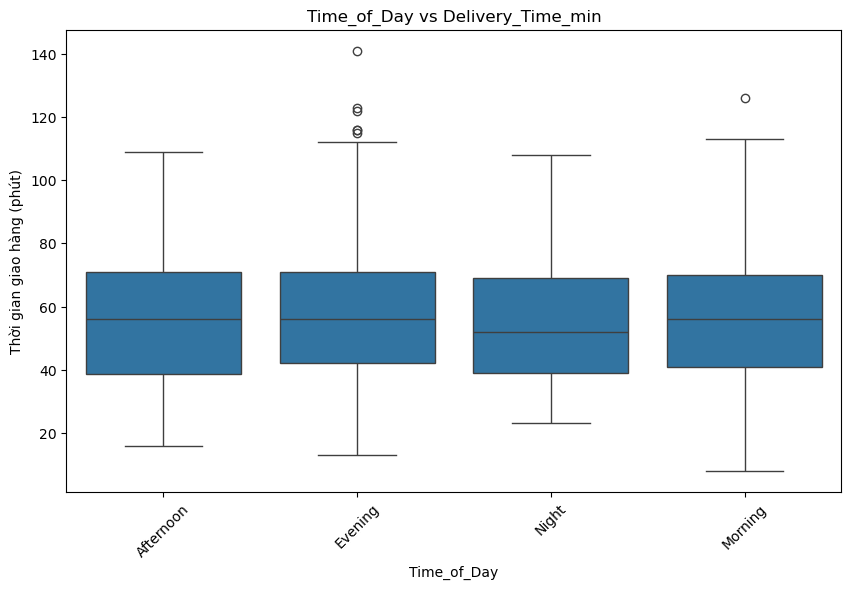

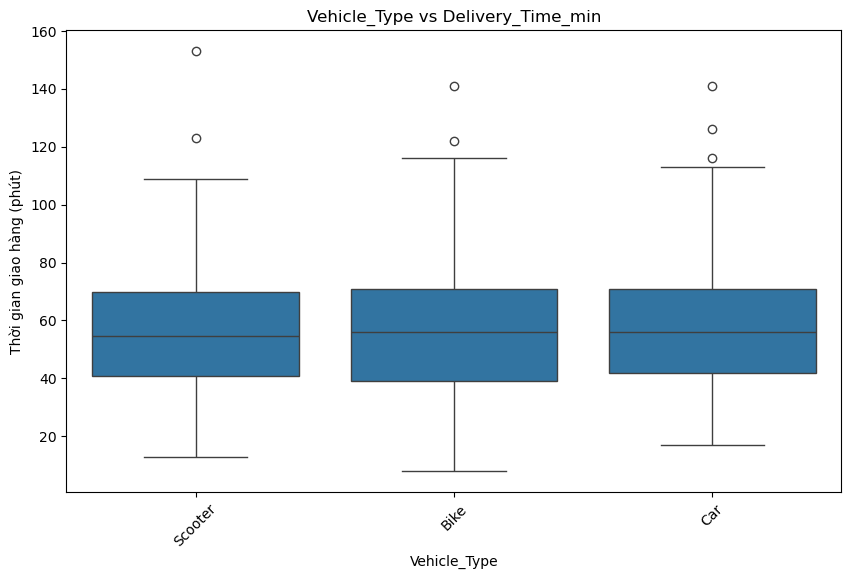

In [47]:
# Phân tích mối quan hệ: Biến hạng mục và Biến mục tiêu
for col in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col], y=df[target_column])
    plt.title(f'{col} vs {target_column}')
    plt.xlabel(col)
    plt.ylabel('Thời gian giao hàng (phút)')
    plt.xticks(rotation=45)
    plt.show()

In [51]:
# Kiểm tra dữ liệu thiếu
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0]) # In những cột có giá trị thiếu

Weather                   30
Traffic_Level             30
Time_of_Day               30
Courier_Experience_yrs    30
dtype: int64


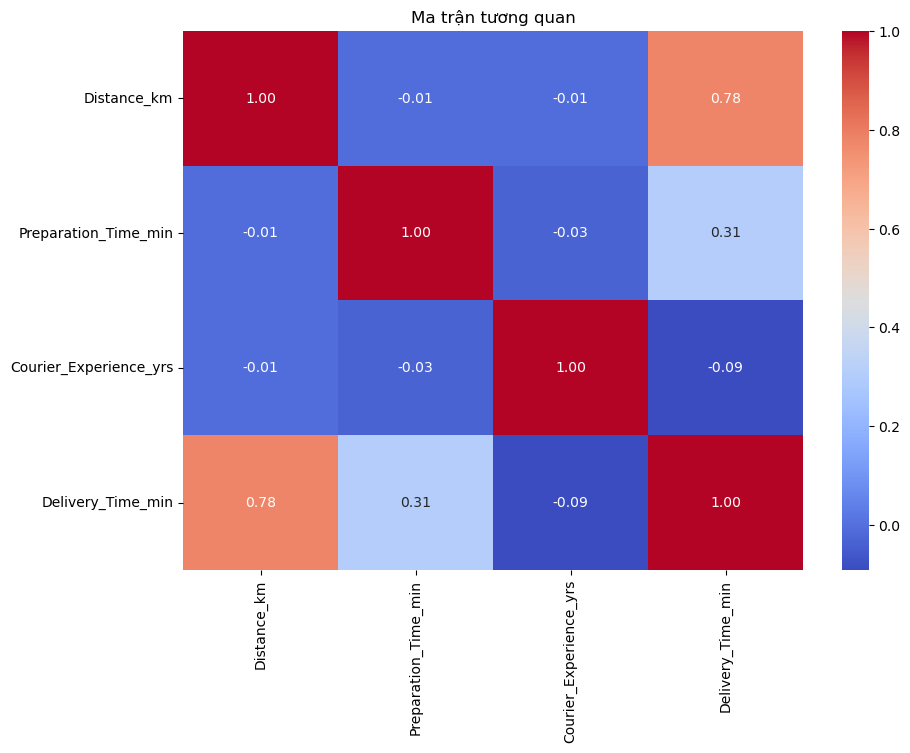


Tương quan với 'Delivery_Time_min':
Delivery_Time_min         1.000000
Distance_km               0.780998
Preparation_Time_min      0.307350
Courier_Experience_yrs   -0.090433
Name: Delivery_Time_min, dtype: float64


In [55]:
# Ma trận tương quan dành cho cột biến số
# Thêm cột mục tiêu vào danh sách để tính tương quan với nó
numerical_with_target = numerical_features + [target_column]
# Chỉ chọn các cột thực sự tồn tại và có kiểu số
numerical_df_corr = df[numerical_with_target].select_dtypes(include=np.number)

if not numerical_df_corr.empty:
    plt.figure(figsize=(10, 7))
    correlation_matrix = numerical_df_corr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Ma trận tương quan')
    plt.show()

    if target_column in correlation_matrix.columns:
      print(f"\nTương quan với '{target_column}':")
      print(correlation_matrix[target_column].sort_values(ascending=False))
else:
    print("Không có đủ cột số để vẽ ma trận tương quan.")

In [29]:
# --- Bước 3: TIỀN XỬ LÝ DỮ LIỆU VÀ KỸ THUẬT ĐẶC TRƯNG ---

# Tách features (X) và target (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Xóa cột ID
if 'Order_ID' in X.columns:
    X = X.drop('Order_ID', axis=1)
    print("Đã xóa cột 'Order_ID'.")

Đã xóa cột 'Order_ID'.


In [31]:
# Tạo Pipelines cho tiền xử lý
# Pipeline cho biến số: Điền thiếu bằng median -> Chuẩn hóa
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [33]:
# Pipeline cho biến hạng mục: Điền thiếu bằng mode -> One-Hot Encoding
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [35]:
# Kết hợp các pipeline bằng ColumnTransformer
transformers_list = []
if numerical_features:
    transformers_list.append(('num', numerical_pipeline, numerical_features))
if categorical_features:
    transformers_list.append(('cat', categorical_pipeline, categorical_features))

# remainder='passthrough' để giữ lại các cột 'extra_features' nếu bạn muốn xem xét chúng sau
# remainder='drop' để loại bỏ các cột không được xử lý
preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='drop'
    )

In [37]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm thử (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện ban đầu: {X_train.shape}")
print(f"Kích thước tập kiểm thử ban đầu: {X_test.shape}")

Kích thước tập huấn luyện ban đầu: (800, 7)
Kích thước tập kiểm thử ban đầu: (200, 7)


In [39]:
# Áp dụng tiền xử lý: fit_transform trên train, transform trên test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Lấy tên các cột sau khi OneHotEncode
feature_names_out = preprocessor.get_feature_names_out()

# Tạo DataFrame từ dữ liệu đã xử lý (chủ yếu để xem và kiểm tra)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_out, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out, index=X_test.index)
print("\nXem thử vài dòng dữ liệu sau tiền xử lý (tập huấn luyện):")
print(X_train_processed_df.head())
print(f"\nKích thước tập huấn luyện sau tiền xử lý: {X_train_processed.shape}")
print(f"Kích thước tập kiểm thử sau tiền xử lý: {X_test_processed.shape}")


Xem thử vài dòng dữ liệu sau tiền xử lý (tập huấn luyện):
     num__Distance_km  num__Preparation_Time_min  num__Courier_Experience_yrs  \
29           1.389200                  -0.980721                     0.820833   
535         -1.391140                   0.126852                    -0.557994   
695         -1.200658                  -0.011595                     1.510246   
557         -0.452710                   1.372871                     0.476126   
836         -0.957750                  -1.257614                    -0.557994   

     cat__Weather_Clear  cat__Weather_Foggy  cat__Weather_Rainy  \
29                  1.0                 0.0                 0.0   
535                 1.0                 0.0                 0.0   
695                 1.0                 0.0                 0.0   
557                 0.0                 0.0                 1.0   
836                 0.0                 0.0                 1.0   

     cat__Weather_Snowy  cat__Weather_Windy  cat__T

In [41]:
# --- Bước 4 & 5: Lựa chọn và Huấn luyện Mô hình ---

# Mô hình 1: Linear Regression (Baseline)
lr_model = LinearRegression()
lr_model.fit(X_train_processed, y_train)
print("Đã huấn luyện xong Linear Regression.")

Đã huấn luyện xong Linear Regression.


In [47]:
# Mô hình 2: Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3)
rf_model.fit(X_train_processed, y_train)
print("Đã huấn luyện xong Random Forest.")

# Mô hình 3: XGBoost (Tùy chọn)
# try:
#     import xgboost as xgb
#     xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42,
#                                   learning_rate=0.1, max_depth=7, subsample=0.8, colsample_bytree=0.8)
#     xgb_model.fit(X_train_processed, y_train)
#     print("Đã huấn luyện xong XGBoost.")
# except ImportError:
#     print("\nThư viện XGBoost chưa được cài đặt. Bỏ qua mô hình XGBoost.")
#     xgb_model = None # Đặt là None nếu không huấn luyện

Đã huấn luyện xong Random Forest.


In [43]:
# --- Bước 6: ĐÁNH GIÁ MÔ HÌNH ---

def evaluate_model(model, X_test, y_test, model_name):
    if model is None:
      print(f"{model_name} không được huấn luyện.")
      return
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n--- Kết quả đánh giá cho {model_name} ---")
    print(f"MAE (Sai số tuyệt đối trung bình): {mae:.4f} phút")
    print(f"RMSE (Sai số căn bậc hai trung bình): {rmse:.4f} phút")
    print(f"R-squared (Hệ số xác định): {r2:.4f}")
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2} # Trả về dict để dễ so sánh

In [49]:
# Đánh giá các mô hình
results = {}
results['Linear Regression'] = evaluate_model(lr_model, X_test_processed, y_test, "Linear Regression")
results['Random Forest'] = evaluate_model(rf_model, X_test_processed, y_test, "Random Forest")
# In bảng so sánh kết quả
results_df = pd.DataFrame(results).T # Chuyển key thành hàng
print("\n--- Bảng so sánh kết quả ---")
print(results_df.sort_values(by='RMSE')) # Sắp xếp theo RMSE (thấp hơn tốt hơn)


--- Kết quả đánh giá cho Linear Regression ---
MAE (Sai số tuyệt đối trung bình): 6.0634 phút
RMSE (Sai số căn bậc hai trung bình): 8.9522 phút
R-squared (Hệ số xác định): 0.8212

--- Kết quả đánh giá cho Random Forest ---
MAE (Sai số tuyệt đối trung bình): 6.7568 phút
RMSE (Sai số căn bậc hai trung bình): 9.5790 phút
R-squared (Hệ số xác định): 0.7953

--- Bảng so sánh kết quả ---
                        MAE      RMSE        R2
Linear Regression  6.063415  8.952171  0.821204
Random Forest      6.756824  9.578966  0.795290


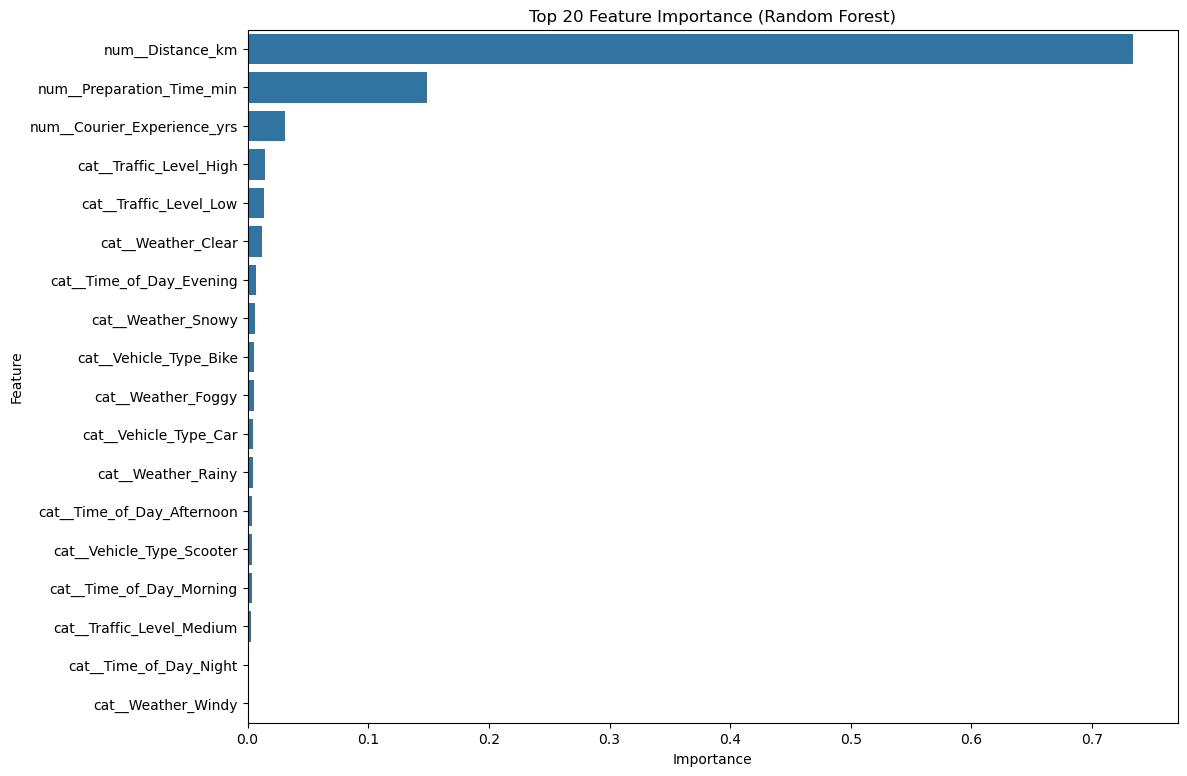


Top 10 Features quan trọng nhất (Random Forest):
                        Feature  Importance
0              num__Distance_km    0.734259
1     num__Preparation_Time_min    0.148596
2   num__Courier_Experience_yrs    0.030938
8       cat__Traffic_Level_High    0.014109
9        cat__Traffic_Level_Low    0.013572
3            cat__Weather_Clear    0.011494
12     cat__Time_of_Day_Evening    0.007004
6            cat__Weather_Snowy    0.006001
15       cat__Vehicle_Type_Bike    0.005558
4            cat__Weather_Foggy    0.004861


In [77]:
# --- Bước 8: TRÌNH BÀY KẾT QUẢ ---

# Phân tích tầm quan trọng của đặc trưng (Feature Importance) - Random Forest
# Kiểm tra xem preprocessor và rf_model đã được huấn luyện thành công chưa
if 'rf_model' in globals() and rf_model is not None and 'feature_names_out' in globals() and feature_names_out is not None:
    try:
        importances = rf_model.feature_importances_
        # Đảm bảo số lượng importances khớp với số lượng tên features
        if len(importances) == len(feature_names_out):
            feature_importance_df = pd.DataFrame({'Feature': feature_names_out, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            plt.figure(figsize=(12, max(6, len(feature_names_out)//2))) # Điều chỉnh chiều cao biểu đồ
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Top 20
            plt.title('Top 20 Feature Importance (Random Forest)')
            plt.show()

            print("\nTop 10 Features quan trọng nhất (Random Forest):")
            print(feature_importance_df.head(10))
        else:
             print(f"Lỗi: Số lượng feature importances ({len(importances)}) không khớp với số lượng tên features ({len(feature_names_out)}).")

    except Exception as e:
        print(f"Lỗi khi lấy/vẽ feature importance: {e}")
else:
    print("\nKhông thể hiển thị Feature Importance (có thể do lỗi ở bước trước hoặc mô hình/tên cột không sẵn sàng).")

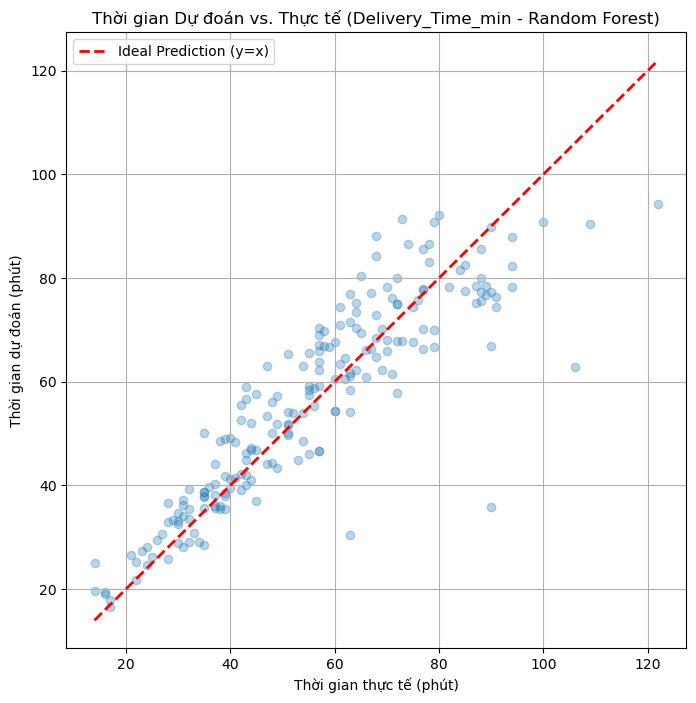

In [79]:
# Trực quan hóa Dự đoán với Thực tế (Random Forest)
if 'rf_model' in globals() and rf_model is not None:
    y_pred_rf = rf_model.predict(X_test_processed)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_rf, alpha=0.3) # Giảm alpha để thấy mật độ điểm
    # Vẽ đường y=x
    min_val = min(y_test.min(), y_pred_rf.min())
    max_val = max(y_test.max(), y_pred_rf.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Ideal Prediction (y=x)')
    plt.xlabel('Thời gian thực tế (phút)')
    plt.ylabel('Thời gian dự đoán (phút)')
    plt.title(f'Thời gian Dự đoán vs. Thực tế ({target_column} - Random Forest)')
    plt.legend()
    plt.grid(True)
    plt.show()


Hệ số của mô hình Linear Regression (sắp xếp theo độ lớn ảnh hưởng):
                        Feature  Coefficient
0              num__Distance_km    17.190207
1     num__Preparation_Time_min     7.022568
8       cat__Traffic_Level_High     5.418788
9        cat__Traffic_Level_Low    -5.260802
6            cat__Weather_Snowy     5.038472
3            cat__Weather_Clear    -4.243399
7            cat__Weather_Windy    -2.637708
2   num__Courier_Experience_yrs    -1.981607
4            cat__Weather_Foggy     1.460801
14       cat__Time_of_Day_Night    -1.179537
12     cat__Time_of_Day_Evening     1.120236
17    cat__Vehicle_Type_Scooter    -0.774415
16        cat__Vehicle_Type_Car     0.685996
5            cat__Weather_Rainy     0.381834
10    cat__Traffic_Level_Medium    -0.157986


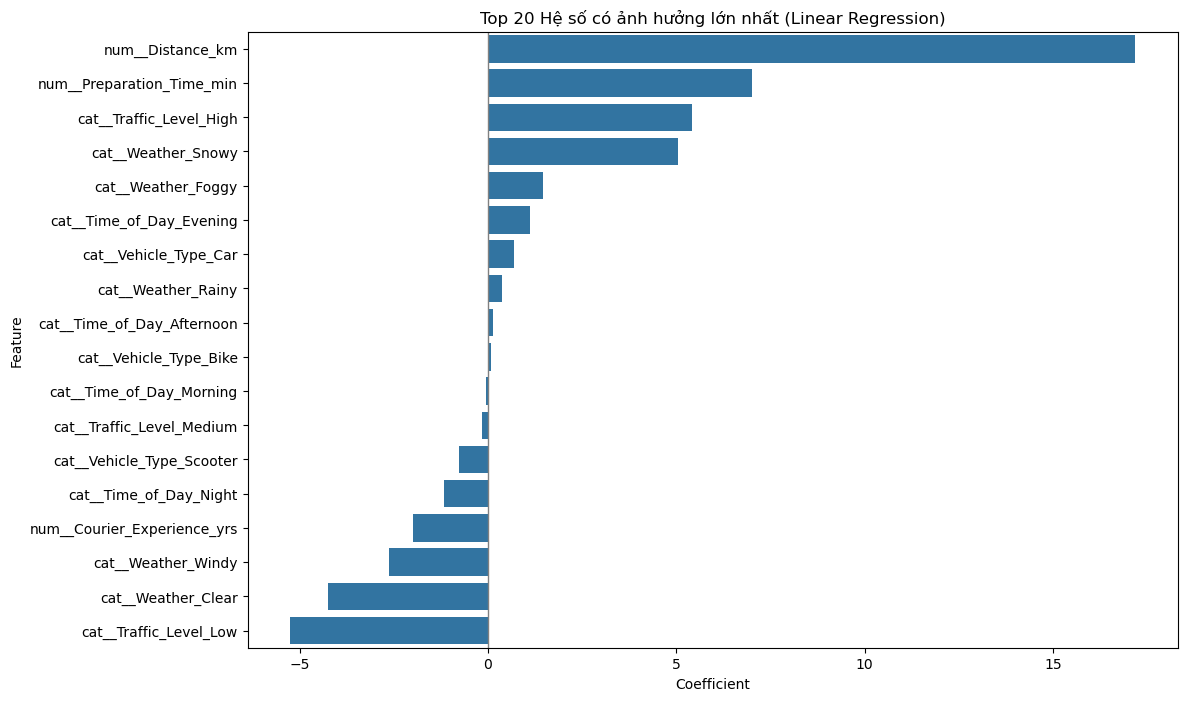


Lưu ý: Hệ số dương nghĩa là feature tăng -> thời gian giao hàng dự kiến tăng.
Hệ số âm nghĩa là feature tăng -> thời gian giao hàng dự kiến giảm.
Độ lớn tuyệt đối của hệ số cho thấy mức độ ảnh hưởng (sau khi đã chuẩn hóa).


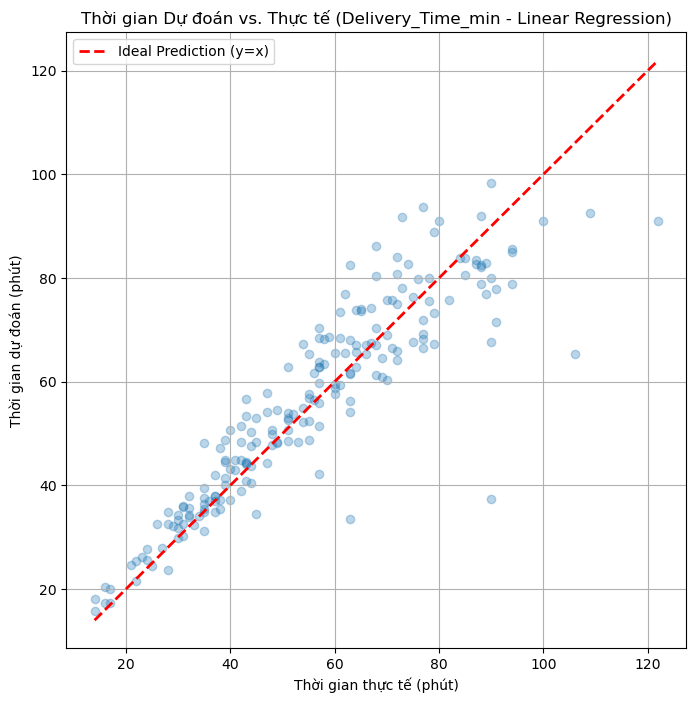

In [51]:
# Kiểm tra xem mô hình Linear Regression và tên cột có tồn tại không
if 'lr_model' in globals() and lr_model is not None and 'feature_names_out' in globals() and feature_names_out is not None:
    try:
        # Lấy các hệ số
        coefficients = lr_model.coef_

        # Đảm bảo số lượng hệ số khớp với số lượng tên features
        if len(coefficients) == len(feature_names_out):
            coeff_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': coefficients})
            # Sắp xếp theo giá trị tuyệt đối của hệ số để xem ảnh hưởng lớn nhất
            coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
            coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

            print("\nHệ số của mô hình Linear Regression (sắp xếp theo độ lớn ảnh hưởng):")
            print(coeff_df[['Feature', 'Coefficient']].head(15))

            # Trực quan hóa các hệ số
            plt.figure(figsize=(12, 8))
            # Lấy top 20 features theo độ lớn hệ số
            coeff_df_display = coeff_df.head(20).sort_values(by='Coefficient', ascending=False) # Sắp xếp lại để vẽ
            sns.barplot(x='Coefficient', y='Feature', data=coeff_df_display, orient='h')
            plt.title('Top 20 Hệ số có ảnh hưởng lớn nhất (Linear Regression)')
            plt.axvline(x=0, color='grey', lw=1) # Thêm đường dọc tại 0 để dễ so sánh âm/dương
            plt.show()

            print("\nLưu ý: Hệ số dương nghĩa là feature tăng -> thời gian giao hàng dự kiến tăng.")
            print("Hệ số âm nghĩa là feature tăng -> thời gian giao hàng dự kiến giảm.")
            print("Độ lớn tuyệt đối của hệ số cho thấy mức độ ảnh hưởng (sau khi đã chuẩn hóa).")

        else:
             print(f"Lỗi: Số lượng hệ số ({len(coefficients)}) không khớp với số lượng tên features ({len(feature_names_out)}).")

    except Exception as e:
        print(f"Lỗi khi lấy/vẽ hệ số Linear Regression: {e}")

    # --- Trực quan hóa Dự đoán vs Thực tế (Linear Regression) ---
    y_pred_lr = lr_model.predict(X_test_processed)
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_lr, alpha=0.3)
    min_val = min(y_test.min(), y_pred_lr.min())
    max_val = max(y_test.max(), y_pred_lr.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2, label='Ideal Prediction (y=x)')
    plt.xlabel('Thời gian thực tế (phút)')
    plt.ylabel('Thời gian dự đoán (phút)')
    plt.title(f'Thời gian Dự đoán vs. Thực tế ({target_column} - Linear Regression)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nKhông thể diễn giải Linear Regression (mô hình lr_model hoặc feature_names_out không sẵn sàng).")

In [53]:
import joblib

model_filename = 'food_delivery_model.joblib'
preprocessor_filename = 'food_delivery_preprocessor.joblib'

# Lưu mô hình
joblib.dump(lr_model, model_filename)

# Lưu preprocessor
joblib.dump(preprocessor, preprocessor_filename)

# Lấy các tên cột gốc mà preprocessor đã học
# Cần lưu lại danh sách này để tạo input DataFrame trong Streamlit
original_feature_names = list(X_train.columns) # Lấy từ X_train trước khi xử lý
print("\nCác tên cột features gốc cần cho input: ", original_feature_names)

# Lấy các lựa chọn cho các biến hạng mục (quan trọng cho selectbox trong Streamlit)
categorical_options = {}
# Giả định X_train là DataFrame gốc trước khi xử lý
for col in categorical_features:
    if col in X_train.columns:
         unique_values = X_train[col].dropna().unique().tolist()
         categorical_options[col] = sorted(unique_values) # Sắp xếp để hiển thị đẹp hơn

print("\nCác lựa chọn cho biến hạng mục: ")
print(categorical_options)


Các tên cột features gốc cần cho input:  ['Distance_km', 'Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type', 'Preparation_Time_min', 'Courier_Experience_yrs']

Các lựa chọn cho biến hạng mục: 
{'Weather': ['Clear', 'Foggy', 'Rainy', 'Snowy', 'Windy'], 'Traffic_Level': ['High', 'Low', 'Medium'], 'Time_of_Day': ['Afternoon', 'Evening', 'Morning', 'Night'], 'Vehicle_Type': ['Bike', 'Car', 'Scooter']}


In [61]:
# ----- 1. Định nghĩa dữ liệu mới -----
new_data_values = {
    'Distance_km': 3.4,
    'Weather': 'Clear',
    'Traffic_Level': 'High',
    'Time_of_Day': 'Morning',
    'Vehicle_Type': 'Motorcycle',
    'Preparation_Time_min': 14,
    'Courier_Experience_yrs': 2
}
print(f"Dữ liệu đầu vào: {new_data_values}")

# ----- 2. Tạo DataFrame một hàng từ dữ liệu mới -----
input_dict = {col: [new_data_values.get(col)] for col in original_feature_names}
new_input = pd.DataFrame(input_dict)

# ----- 3. Áp dụng preprocessor (BẮT BUỘC) -----
new_input_processed = preprocessor.transform(new_input)

# ----- 4. Dự đoán với mô hình -----
# model_to_use là biến chứa mô hình đã huấn luyện của bạn (lr_model)
prediction_raw = lr_model.predict(new_input_processed)
predicted_duration = round(prediction_raw[0], 1) # Lấy kết quả và làm tròn

# ----- 5. In kết quả -----
print(f"Dự đoán khoảng thời gian chỉ giao hàng: {predicted_duration} phút")

# Tính tổng thời gian từ lúc đặt (bao gồm chuẩn bị)
total_duration_with_prep = new_data_values['Preparation_Time_min'] + predicted_duration
print(f"Tổng thời gian cần thiết (gồm chuẩn bị): {total_duration_with_prep:.1f} phút")

Dữ liệu đầu vào: {'Distance_km': 3.4, 'Weather': 'Clear', 'Traffic_Level': 'High', 'Time_of_Day': 'Morning', 'Vehicle_Type': 'Motorcycle', 'Preparation_Time_min': 14, 'Courier_Experience_yrs': 2}
Dự đoán khoảng thời gian chỉ giao hàng: 39.5 phút
Tổng thời gian cần thiết (gồm chuẩn bị): 53.5 phút
